#### The Spotify Effect
##### Acevedo, Contreras y Razmilic (2024)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.ticker as mticker

# -----------------------------------------------------------------------------
# 1) Define file paths and read the CSV files into DataFrames
# -----------------------------------------------------------------------------
artist_metadata_path = r"C:\Users\raimu\Dropbox\TSE\Data\spotify\artist_metadata.csv"
spotify_data_path = r"C:\Users\raimu\Dropbox\TSE\Data\spotify\spotify.csv"
spotify_work_path = r"C:\Users\raimu\Dropbox\TSE\Data\spotify\spotify_work.csv"

# Read CSV data
df_metadata = pd.read_csv(artist_metadata_path)
df_spotify = pd.read_csv(spotify_data_path)
df_spotify_work = pd.read_csv(spotify_work_path)

C:\Users\raimu\AppData\Local\Temp\ipykernel_6320\2005880630.py:18: DtypeWarning: Columns (32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df_spotify_work = pd.read_csv(spotify_work_path)


C:\Users\raimu\AppData\Local\Temp\ipykernel_6320\3248381228.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['popularity_zscore'].fillna(0, inplace=True)


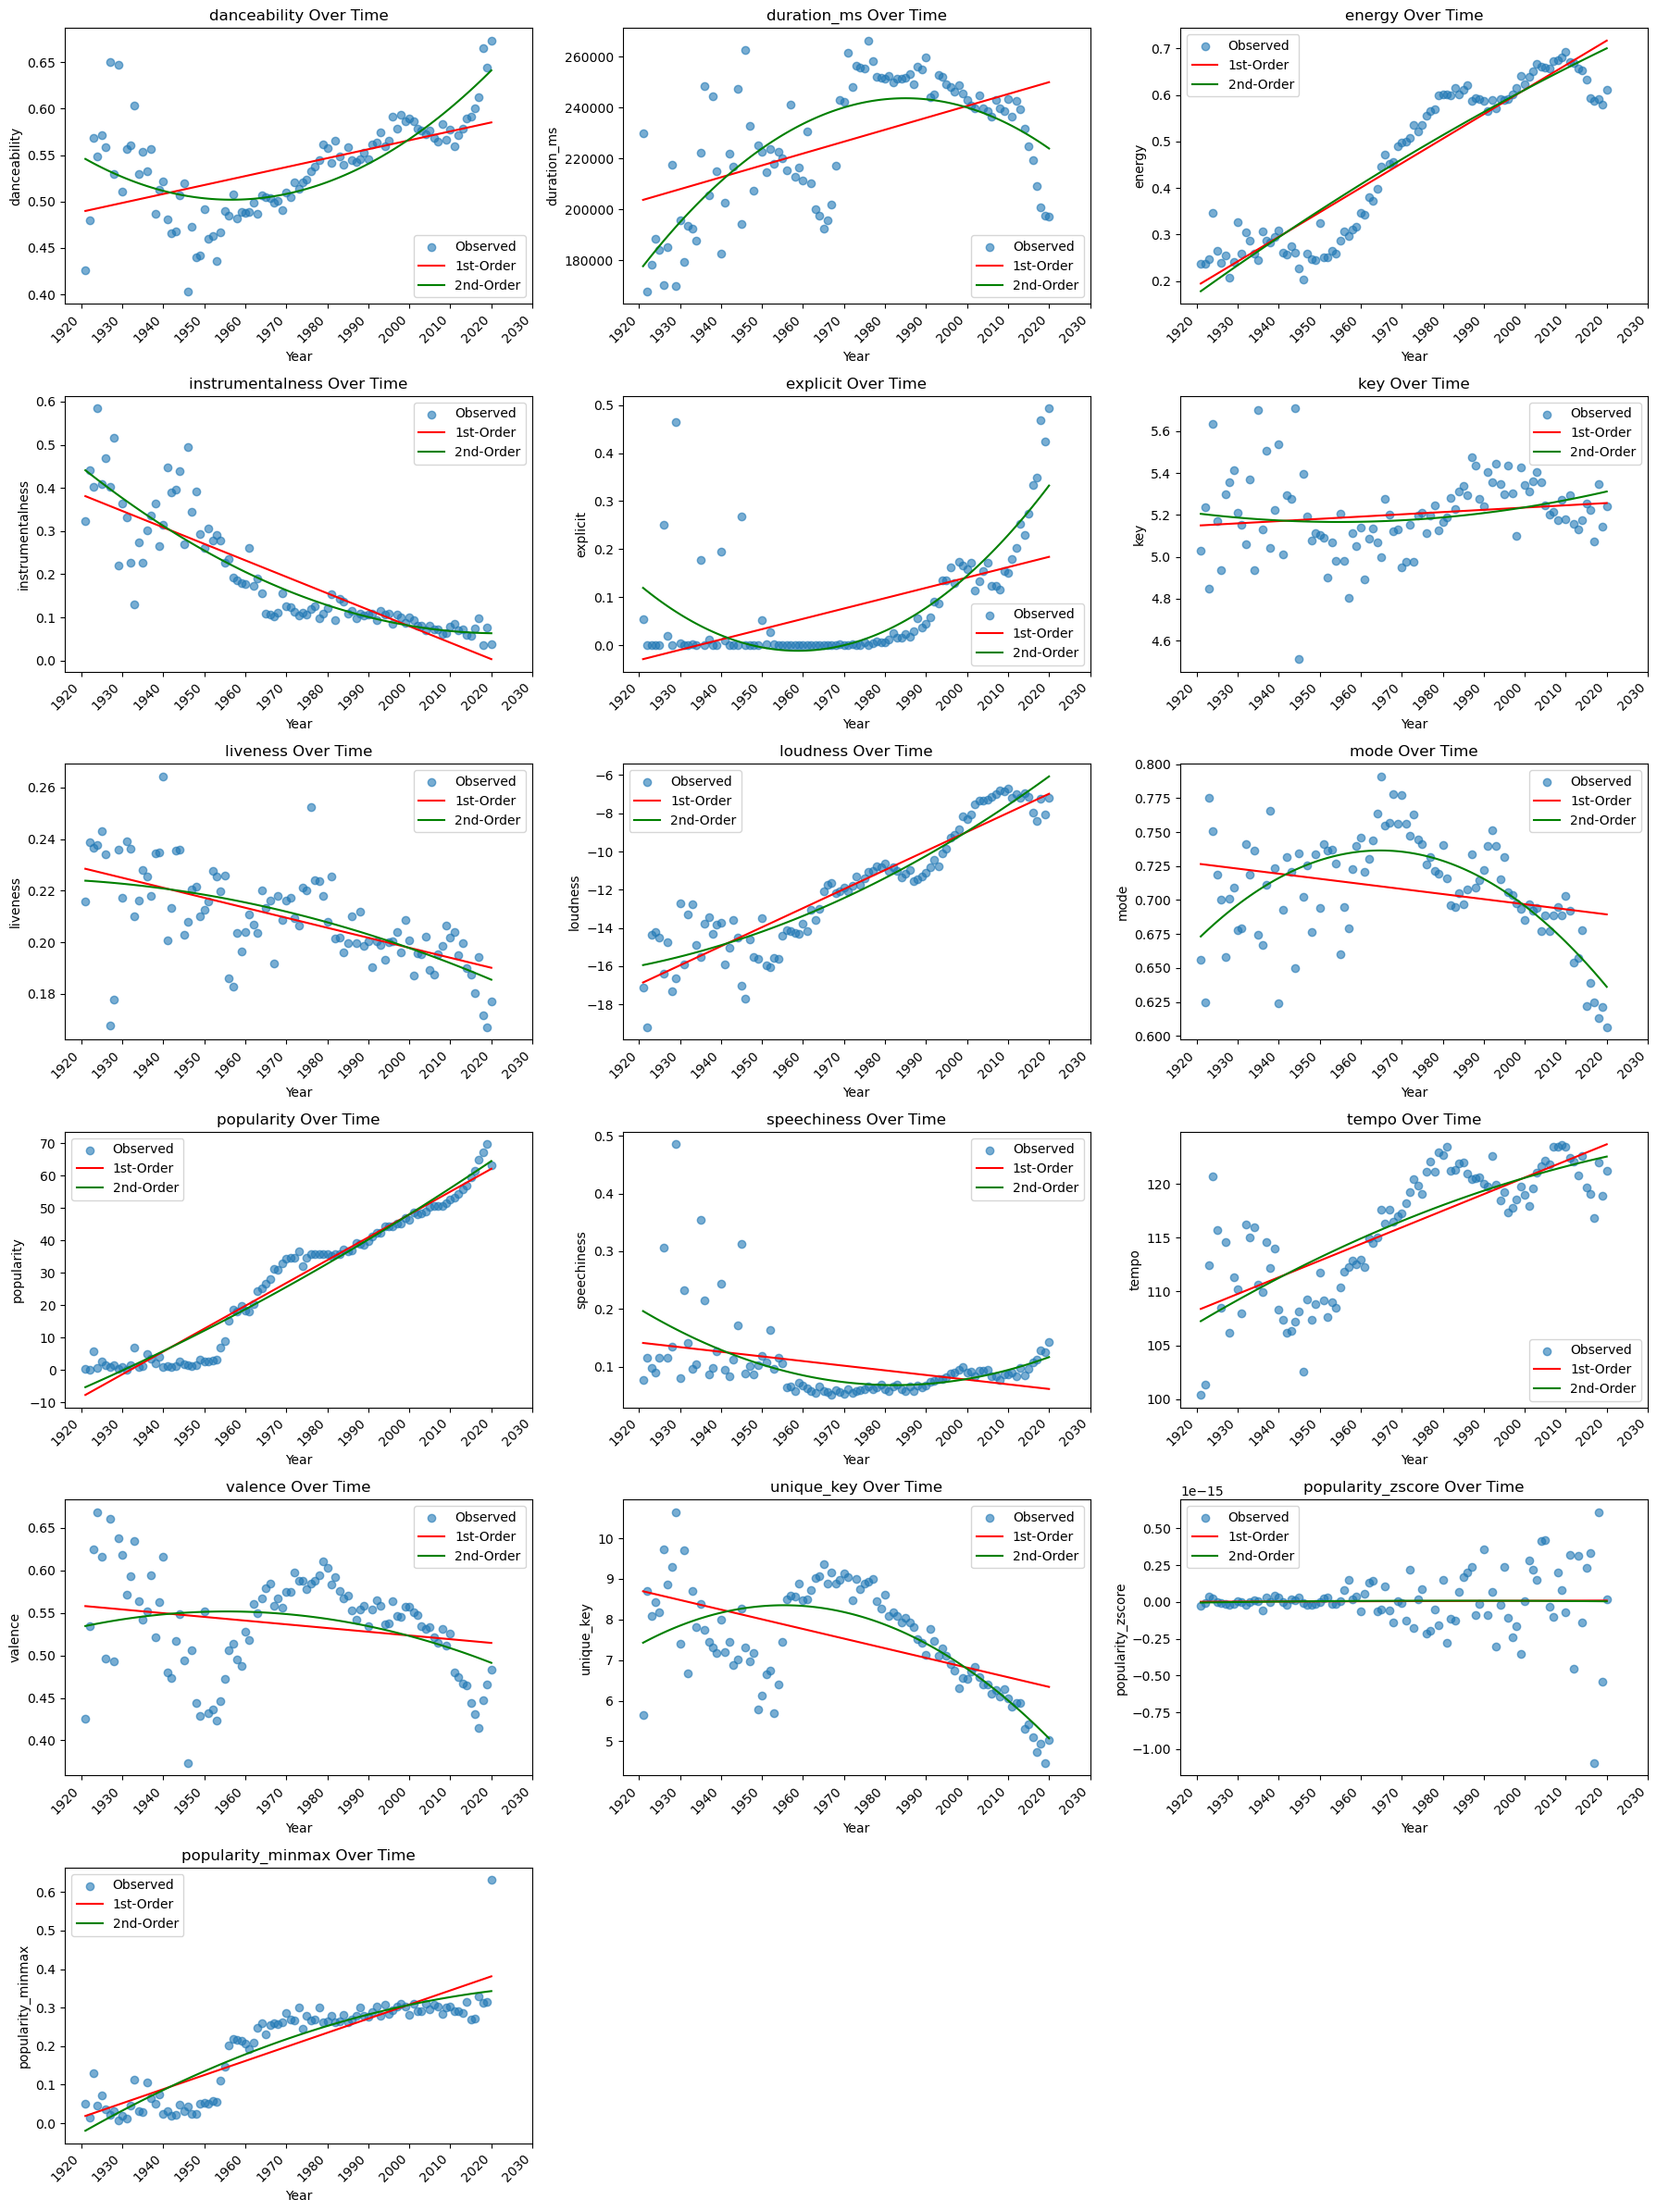

In [2]:

# -----------------------------------------------------------------------------
# 2) Clean the 'artists' column in df_spotify
# -----------------------------------------------------------------------------
df_spotify['artists'] = df_spotify['artists'].astype(str)
df_spotify['artists'] = df_spotify['artists'].str.replace(r"\['", " ", regex=True)
df_spotify['artists'] = df_spotify['artists'].str.replace(r"'\]", " ", regex=True)
df_spotify['artists'] = df_spotify['artists'].str.replace(r"', '", " ", regex=True)

# -----------------------------------------------------------------------------
# 3) Rename 'artist' to 'artists' in the metadata, then merge
# -----------------------------------------------------------------------------
df_metadata.rename(columns={'artist': 'artists'}, inplace=True)

# Merge the DataFrames on 'artists' with an outer join
df_merged = pd.merge(df_spotify, df_metadata, how='outer', on='artists')

# -----------------------------------------------------------------------------
# 4) Calculate unique count of 'key' by 'artists'
# -----------------------------------------------------------------------------
df_merged['unique_key'] = df_merged.groupby('artists')['key'].transform('nunique')

# -----------------------------------------------------------------------------
# 4a) Standardize 'popularity' using z-score within each year
# -----------------------------------------------------------------------------
df_merged['popularity_zscore'] = (
    df_merged
    .groupby('year')['popularity']
    .transform(lambda x: (x - x.mean()) / x.std())
)

# Handle potential NaNs resulting from zero standard deviation (e.g., only one song in a year)
df_merged['popularity_zscore'].fillna(0, inplace=True)

# -----------------------------------------------------------------------------
# 4b) Standardize 'popularity' using min-max scaling within each year
# -----------------------------------------------------------------------------
df_merged['popularity_minmax'] = (
    df_merged
    .groupby('year')['popularity']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0)
)

# -----------------------------------------------------------------------------
# 5) Collapse (group) by 'year' and compute mean for selected columns
# -----------------------------------------------------------------------------
collapse_cols = [
    'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'explicit', 'key', 'liveness', 'loudness', 'mode',
    'popularity', 'speechiness', 'tempo', 'valence', 'unique_key',
    'popularity_zscore', 'popularity_minmax'
]

df_collapse = (
    df_merged
    .groupby('year', as_index=False)[collapse_cols]
    .mean(numeric_only=True)  # For pandas 2.0+ which requires numeric_only
)

# -----------------------------------------------------------------------------
# 6) Prepare for Plotting: Fit Regressions and Create Subplots
# -----------------------------------------------------------------------------
variables_to_plot = collapse_cols  # same as above

# Convert 'year' to numeric, just in case
df_collapse['year'] = pd.to_numeric(df_collapse['year'], errors='coerce')
df_collapse.dropna(subset=['year'], inplace=True)  # Remove rows where 'year' is NaN
df_collapse.sort_values('year', inplace=True)

X = df_collapse[['year']].values  # shape (n, 1)

# Create figure with 15 subplots: 5 rows x 3 columns
num_vars = len(variables_to_plot)
ncols = 3
nrows = int(np.ceil(num_vars / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows), sharex=False)
axes = axes.flatten()

# Define your tick interval
tick_interval = 10
min_year = int(df_collapse['year'].min())
max_year = int(df_collapse['year'].max()) + 1
tick_years = range(min_year - (min_year % tick_interval), max_year + tick_interval, tick_interval)

for i, var in enumerate(variables_to_plot):
    if i >= len(axes):
        print(f"Warning: More variables to plot ({len(variables_to_plot)}) than subplots ({len(axes)}).")
        break  # Prevent IndexError
    
    ax = axes[i]
    y = df_collapse[var].values

    # -- 1) Linear regression --
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    y_pred_linear = lin_reg.predict(X)

    # -- 2) Polynomial (2nd-order) regression --
    poly_features = PolynomialFeatures(degree=2)
    X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)
    y_pred_poly = poly_reg.predict(X_poly)

    # Scatter: observed data
    ax.scatter(df_collapse['year'], y, label='Observed', alpha=0.6)

    # Plot: 1st-order fit
    ax.plot(df_collapse['year'], y_pred_linear, color='red', label='1st-Order')

    # Plot: 2nd-order fit
    ax.plot(df_collapse['year'], y_pred_poly, color='green', label='2nd-Order')

    # Set title and labels
    ax.set_title(f"{var} Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel(var)
    ax.legend()

    # Force x-axis ticks every 10 years (or whatever interval you choose)
    ax.set_xticks(tick_years)
    ax.set_xticklabels([str(year) for year in tick_years], rotation=45, ha='right')  # as strings with rotation

# Remove any unused subplots
for j in range(len(variables_to_plot), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

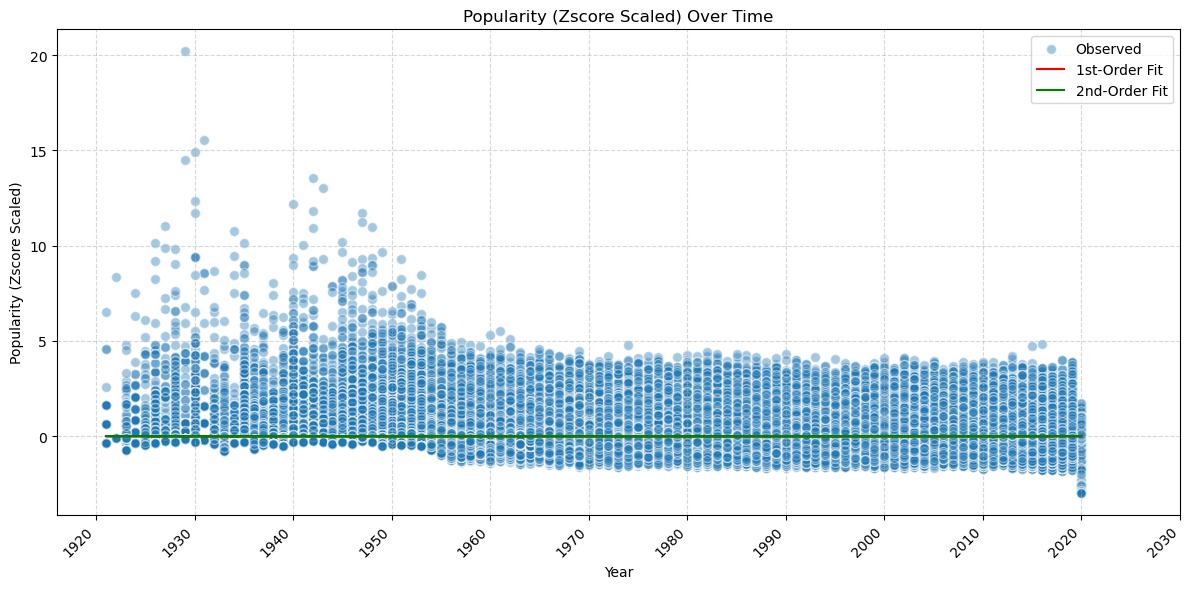

In [6]:

# Extract 'year' and 'popularity_minmax'
X = df_merged[['year']].values  # Predictor
y = df_merged['popularity_zscore'].values  # Response
# Drop rows where 'year' or 'popularity_minmax' is NaN
df_merged_clean = df_merged.dropna(subset=['year', 'popularity_zscore'])

# Extract 'year' and 'popularity_minmax'
X = df_merged_clean[['year']].values  # Predictor (reshape to 2D array)
y = df_merged_clean['popularity_zscore'].values  # Response

# --- Linear Regression ---
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_linear = lin_reg.predict(X)

# --- Polynomial (2nd-order) Regression ---
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
y_pred_poly = poly_reg.predict(X_poly)


# Define tick interval (e.g., every 10 years)
tick_interval = 10
min_year = int(df_merged_clean['year'].min())
max_year = int(df_merged_clean['year'].max()) + 1
tick_years = range(min_year - (min_year % tick_interval), max_year + tick_interval, tick_interval)

# Create the plot
plt.figure(figsize=(12, 6))

# Scatter Plot: Observed Data
plt.scatter(df_merged_clean['year'], y, label='Observed', alpha=0.4, edgecolors='w', s=50)

# Linear Regression Line
plt.plot(df_merged_clean['year'], y_pred_linear, color='red', label='1st-Order Fit')

# Polynomial Regression Line
plt.plot(df_merged_clean['year'], y_pred_poly, color='green', label='2nd-Order Fit')

# Customize X-axis
plt.xlabel('Year')
plt.ylabel('Popularity (Zscore Scaled)')
plt.title('Popularity (Zscore Scaled) Over Time')
plt.xticks(tick_years)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(tick_interval))
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

# Add Legend
plt.legend()

# Add Grid for Better Readability
plt.grid(True, linestyle='--', alpha=0.5)

# Improve Layout
plt.tight_layout()

# Display the Plot
plt.show()